<a href="https://colab.research.google.com/github/dansojo/Medical_CV/blob/main/part1_efficientnetB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import Dropout
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import efficientnet_b1
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
# 설정 값
class Config:
    TRAIN_PATH = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/part1_datasets/train_dataset.pt"
    VAL_PATH = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/part1_datasets/val_dataset.pt"
    TEST_PATH = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/part1_datasets/test_dataset.pt"
    BATCH_SIZE = 32
    EPOCHS = 20
    LR = 0.001
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 데이터 로드 함수
def load_data(train_path, val_path, test_path):
    train_images, train_labels = torch.load(train_path)
    val_images, val_labels = torch.load(val_path)
    test_images, test_labels = torch.load(test_path)

    train_dataset = TensorDataset(train_images, train_labels)
    val_dataset = TensorDataset(val_images, val_labels)
    test_dataset = TensorDataset(test_images, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:

# EfficientNet-B1 모델 정의
def get_efficientnet_model(num_classes=7):
    model = efficientnet_b1(weights='DEFAULT')  # pretrained=True 대신 weights='DEFAULT' 사용
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),  # Dropout 추가 (p는 드롭 확률, 50%)
        nn.Linear(model.classifier[1].in_features, num_classes)  # 기존 선형 레이어
    )
    return model.to(Config.DEVICE)

In [ ]:
# 학습 함수
def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LR)

    for epoch in range(Config.EPOCHS):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{Config.EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_accuracy = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Validation Loss 계산
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_accuracy.append(accuracy_score(labels.cpu(), preds.cpu()))
        # Training/Validation Loss와 Validation Accuracy 출력
        print(f"Epoch [{epoch+1}/{Config.EPOCHS}], "
              f"Training Loss: {running_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {sum(val_accuracy)/len(val_accuracy):.4f}")

In [ ]:
# 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 평가 지표
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

In [ ]:
train_loader, val_loader, test_loader = load_data(Config.TRAIN_PATH, Config.VAL_PATH, Config.TEST_PATH)

<ipython-input-3-76246b475679>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_images, train_labels = torch.load(train_path)
<ipython-input-3-76246b475679>:4: FutureW

In [ ]:
model = get_efficientnet_model()
train_model(model, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 34.3MB/s]


Epoch [1/20], Loss: 0.8850
Epoch [1/20], Training Loss: 0.8850, Validation Loss: 0.7864, Validation Accuracy: 0.7773
Epoch [2/20], Loss: 0.5724
Epoch [2/20], Training Loss: 0.5724, Validation Loss: 0.5621, Validation Accuracy: 0.8047
Epoch [3/20], Loss: 0.4530
Epoch [3/20], Training Loss: 0.4530, Validation Loss: 0.5980, Validation Accuracy: 0.7930
Epoch [4/20], Loss: 0.2962
Epoch [4/20], Training Loss: 0.2962, Validation Loss: 0.6248, Validation Accuracy: 0.7900
Epoch [5/20], Loss: 0.2279
Epoch [5/20], Training Loss: 0.2279, Validation Loss: 0.7875, Validation Accuracy: 0.7930
Epoch [6/20], Loss: 0.1660
Epoch [6/20], Training Loss: 0.1660, Validation Loss: 0.6957, Validation Accuracy: 0.8164
Epoch [7/20], Loss: 0.1152
Epoch [7/20], Training Loss: 0.1152, Validation Loss: 0.7368, Validation Accuracy: 0.8223
Epoch [8/20], Loss: 0.0996
Epoch [8/20], Training Loss: 0.0996, Validation Loss: 0.7669, Validation Accuracy: 0.8213
Epoch [9/20], Loss: 0.0654
Epoch [9/20], Training Loss: 0.0654, 

In [ ]:
evaluate_model(model, test_loader)

Test Accuracy: 0.8010
F1 Score: 0.7944
Confusion Matrix:
[[ 70  26   6   2   0   8   1]
 [ 25 634   5  10   5   6   2]
 [  3   2   4   0   0   1   1]
 [ 20  31   0  28   3   4   1]
 [  0   1   0   2  10   0   0]
 [  2   3   1   0   2  43   2]
 [ 10   4   3   2   0   5  12]]


In [ ]:
# 모델 저장
def save_entire_model(model, save_path):
    torch.save(model, save_path)
    print(f"Entire model saved to {save_path}")

# 예시 - 학습 후 저장
save_path = "/content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/part1_datasets/part1_efficientnetB1_model.pth"
save_entire_model(model, save_path)

Entire model saved to /content/drive/MyDrive/Medical_CV/피부암 분류 및 Segmentation/part1_datasets/part1_efficientnetB1_model.pth


In [ ]:
# Confusion Matrix 시각화 함수
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# 클래스 이름 정의
class_names = ["bkl", "nv", "df", "mel", "vasc", "bcc", "akiec"]

# 모델 평가 및 Confusion Matrix 생성
def evaluate_and_plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # 예측값
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix 시각화
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # 테스트 정확도 출력
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

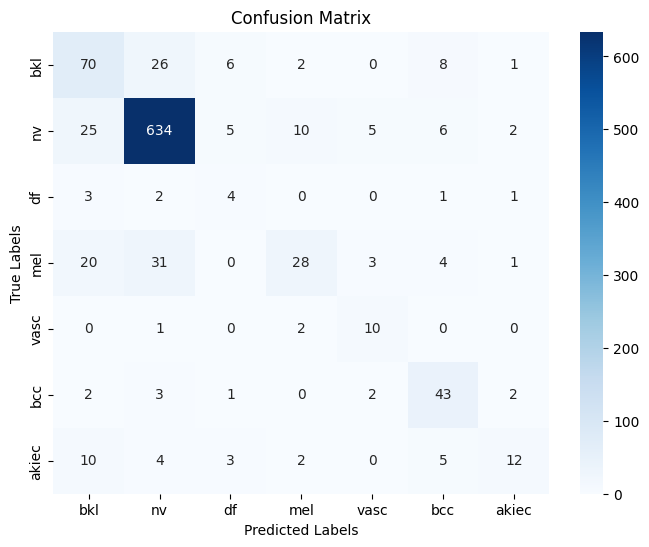

Test Accuracy: 0.8010


In [ ]:
evaluate_and_plot_confusion_matrix(model, test_loader, class_names)

In [ ]:
# 성능 지표 시각화 함수
def plot_classification_metrics(true_labels, predicted_labels, class_names):
    # Classification Report 생성
    report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

    # Precision, Recall, F1 Score 추출
    metrics = ['precision', 'recall', 'f1-score']
    scores = {metric: [report[label][metric] for label in class_names] for metric in metrics}

    # 그래프 그리기
    x = np.arange(len(class_names))
    width = 0.2

    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(metrics):
        plt.bar(x + i * width, scores[metric], width, label=metric)

    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Classification Metrics by Class')
    plt.xticks(x + width, class_names, rotation=45)
    plt.ylim(0, 1)  # 점수 범위를 0~1로 고정
    plt.legend()
    plt.tight_layout()
    plt.show()

# 클래스 이름 정의
class_names = ["bkl", "nv", "df", "mel", "vasc", "bcc", "akiec"]

# 모델 평가 및 성능 지표 시각화
def evaluate_and_plot_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # 예측값
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 성능 지표 그래프 그리기
    plot_classification_metrics(all_labels, all_preds, class_names)

    # Classification Report 출력
    print(classification_report(all_labels, all_preds, target_names=class_names))


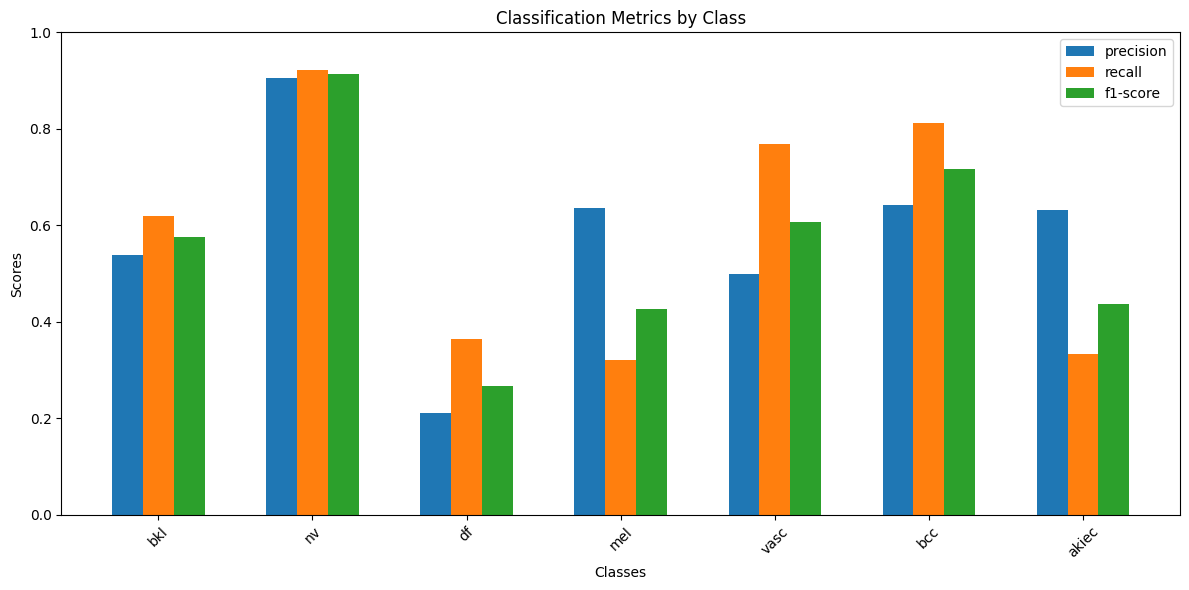

              precision    recall  f1-score   support

         bkl       0.54      0.62      0.58       113
          nv       0.90      0.92      0.91       687
          df       0.21      0.36      0.27        11
         mel       0.64      0.32      0.43        87
        vasc       0.50      0.77      0.61        13
         bcc       0.64      0.81      0.72        53
       akiec       0.63      0.33      0.44        36

    accuracy                           0.80      1000
   macro avg       0.58      0.59      0.56      1000
weighted avg       0.80      0.80      0.79      1000



In [ ]:
evaluate_and_plot_metrics(model, test_loader, class_names)